# Разработка плана действий по удержанию клиентов для сети фитнес-центров «Культурист-датасаентист»

**Описание исследования:**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.

Для фитнес-центра считаем, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

Для анализа предоставлены оцифрованные данные клиентов.

**Описание данных:**
Данные клиента за предыдущий до проверки факта оттока месяц:
* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* 'Churn' — факт оттока в текущем месяце.

**Цели исследования:**

* Спрогнозировать вероятность оттока для каждого клиента;
* Сформировать типичные портреты клиентов;
* Проанализировать основные признаки, наиболее сильно влияющие на отток;
* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
* 1) выделить целевые группы клиентов;
* 2) предложить меры по снижению оттока;
* 3) определить другие особенности взаимодействия с клиентами.

**План:**

1. [Предобработка данных](#1)
2. [Исследование данных](#2)
3. [Модель прогнозирования оттока клиентов](#3)
4. [Кластеризация клиентов](#4)
5. [Вывод](#5)

## Предобработка данных <a id="1"></a>

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import numpy as np
import math as mth
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

In [2]:
# чтение файла из csv
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# смотрю пропуски, признаки и типы данных
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Всего 4000 наблюдений, 12 признаков, пропусков нет. Все признаки приведены к числовому формату.

In [4]:
# Привожу названия колонок подобающему виду
df.columns = df.columns.str.lower()

### Аномалии

In [5]:
churn = []
remain = []
# смотрю аномалии отдельно по оставшимся и ушедшим клиентам. Записываю числа в списки соответсвующие
for i in df.columns:
    print('Ушедшие', i, np.percentile(df.query('churn==1')[i], [99]))
    print('Оставшиеся', i, np.percentile(df.query('churn==0')[i], [99]))
    print()
    churn.append(float(np.percentile(df.query('churn==1')[i], [99])))
    remain.append(float(np.percentile(df.query('churn==0')[i], [99])))

Ушедшие gender [1.]
Оставшиеся gender [1.]

Ушедшие near_location [1.]
Оставшиеся near_location [1.]

Ушедшие partner [1.]
Оставшиеся partner [1.]

Ушедшие promo_friends [1.]
Оставшиеся promo_friends [1.]

Ушедшие phone [1.]
Оставшиеся phone [1.]

Ушедшие contract_period [12.]
Оставшиеся contract_period [12.]

Ушедшие group_visits [1.]
Оставшиеся group_visits [1.]

Ушедшие age [34.]
Оставшиеся age [37.]

Ушедшие avg_additional_charges_total [307.11389589]
Оставшиеся avg_additional_charges_total [413.80826066]

Ушедшие month_to_end_contract [12.]
Оставшиеся month_to_end_contract [12.]

Ушедшие lifetime [5.]
Оставшиеся lifetime [18.62]

Ушедшие avg_class_frequency_total [3.04948547]
Оставшиеся avg_class_frequency_total [4.26085187]

Ушедшие avg_class_frequency_current_month [3.0585654]
Оставшиеся avg_class_frequency_current_month [4.37132921]

Ушедшие churn [1.]
Оставшиеся churn [0.]



## Исследовательский анализ данных <a id="2"></a>

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [7]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


* 18% уходят из тех, у кого были промо от друзей. У ушедших клиентов в среднем 1.7 месяца активного абонемента. 
* 27% посещали групповые занятия, это не помешало им уйти. 
* В среднем ушедшим 27 лет, не так важно, а не ушедшим 30, не такая большая разница, чтобы делать выводы. 
* Ушедшие в среднем платят меньше на доп услуги - 115 у.е. 
* 1.66 месяца до оконачния абонемента у ушедших. 
* Время с момента первого обращения в фитнес-центр у ушедших в среднем намного ниже, чем у оставшихся - 0.99 месяца против 4.71.
* Средняя частота посещения в неделю за месяц в два раза меньше, чем у оставшихся - 1.04

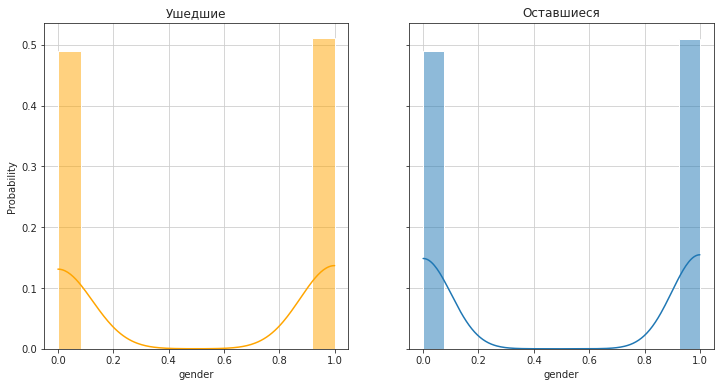

<Figure size 432x288 with 0 Axes>

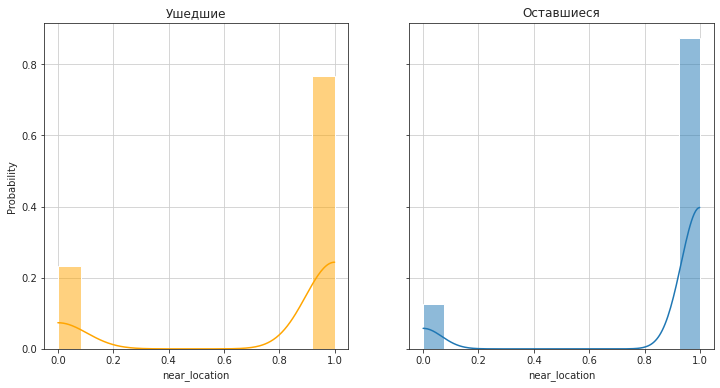

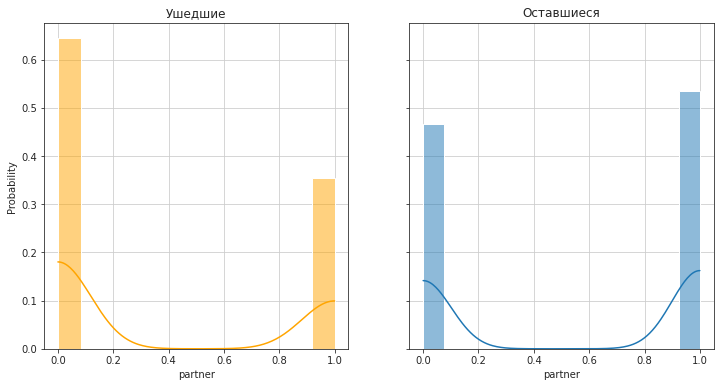

<Figure size 432x288 with 0 Axes>

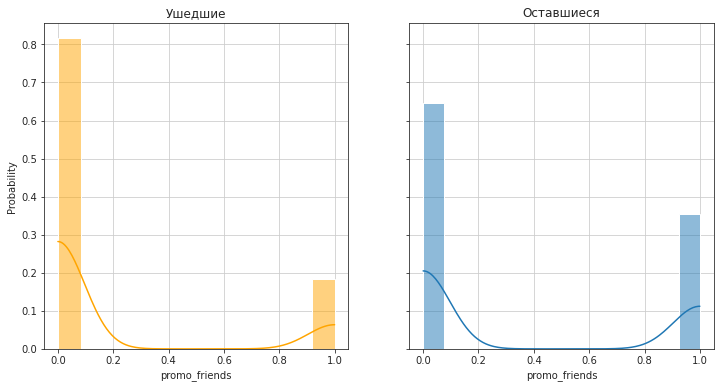

<Figure size 432x288 with 0 Axes>

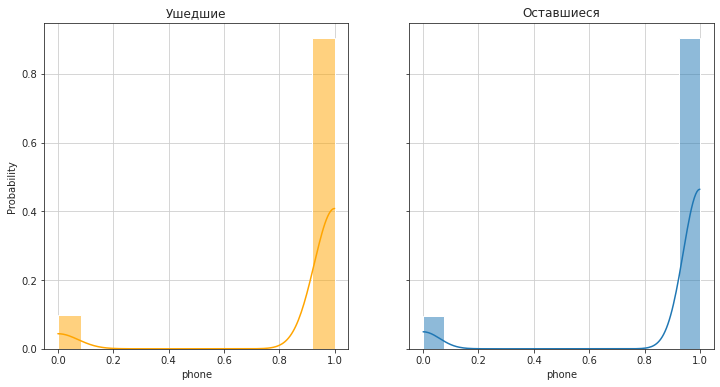

<Figure size 432x288 with 0 Axes>

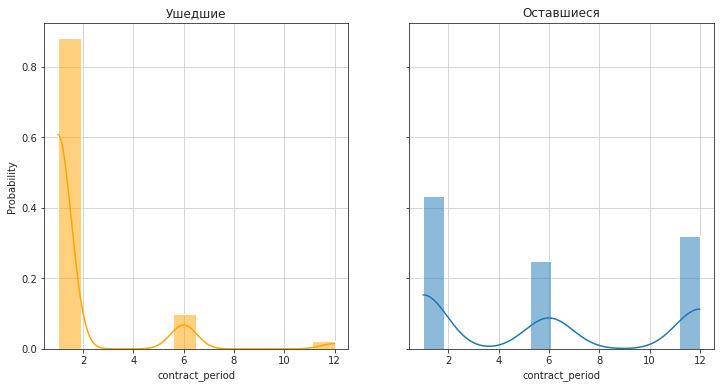

<Figure size 432x288 with 0 Axes>

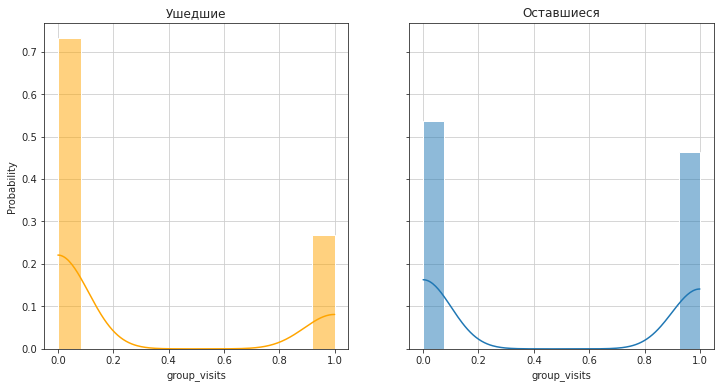

<Figure size 432x288 with 0 Axes>

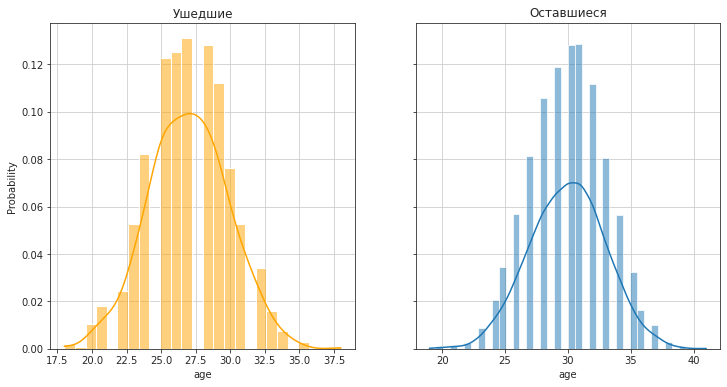

<Figure size 432x288 with 0 Axes>

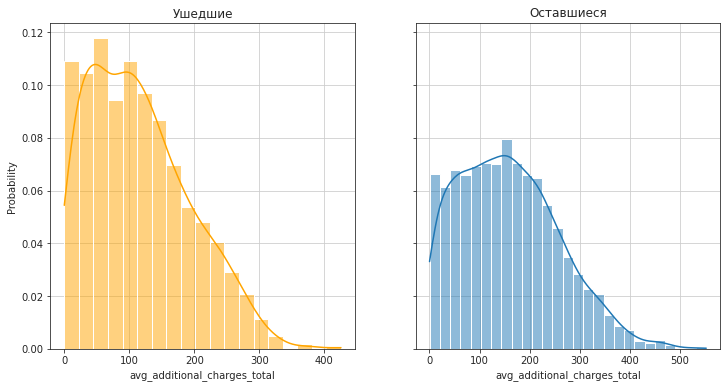

<Figure size 432x288 with 0 Axes>

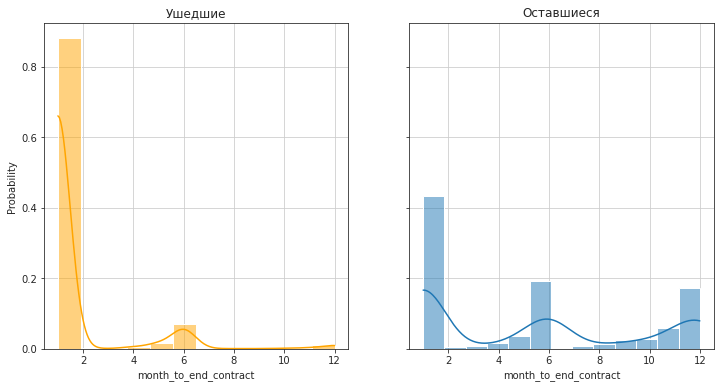

<Figure size 432x288 with 0 Axes>

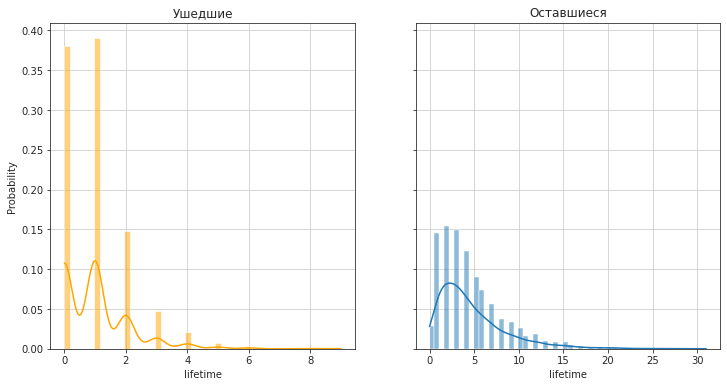

<Figure size 432x288 with 0 Axes>

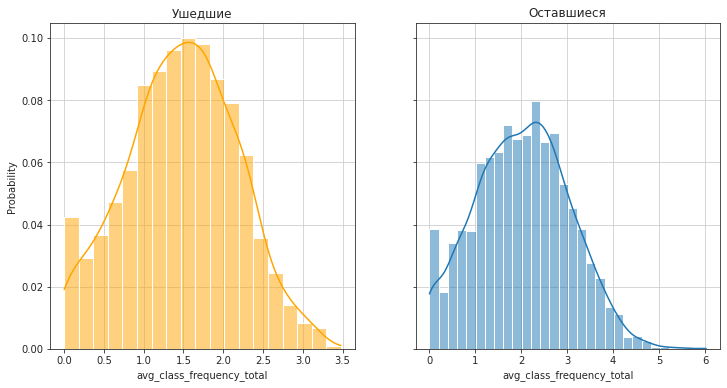

<Figure size 432x288 with 0 Axes>

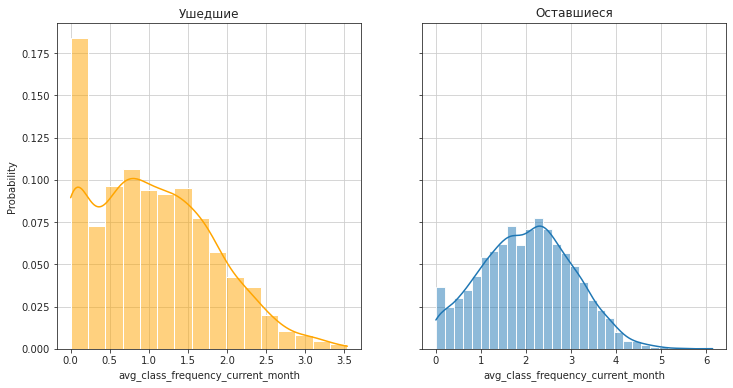

<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


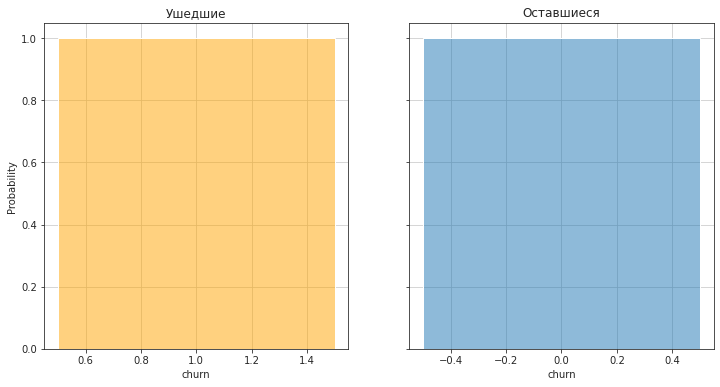

<Figure size 432x288 with 0 Axes>

In [8]:
sns.set_style("ticks",{'axes.grid' : True})
for i, col in enumerate(df.columns):
    fig, ((ax1), (ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), sharey=True)
    plt.figure(i)
    sns.histplot(df.query('churn==1')[col], color="orange", ax=ax1, kde=True, stat='probability').set(title='Ушедшие')   
    sns.histplot(df.query('churn==0')[col], ax=ax2, kde=True, stat='probability').set(title='Оставшиеся')
    plt.show()

Исходя из гистограмм, наиболее разительные отличия между ушедшими и оставшимися клиенатами выявлены в следующих признаках:

* Из ушедших у 65% не было партнерской скидки(у 35% была), из оставшихся у 53%
* Из ушедших у 82% не было скидки от друзей(у 18% была), из оставшихся у 65%
* Из ушедших у 86% длительность текущего действующего абонемента составляла менее 2 месяцев
* Из ушедших 27% посещали групповые занятия
* Из ушедших у 86% срок до окончания текущего действующего абонемента составлял меньше 2 месяцев
* Из ушедших у большей части время с момента первого обращения в фитнес-центр не достигало 2 месяцев. У 40% - один месяц, у 38% меньше месяца
* Из ушедших средняя частота посещений в неделю за все время с начала действия абонемента  у большинства 1.5
* У ушедших распределение средней частоты посещений в неделю за предыдущий месяц смещено влево. У оставшихся есть тяжелый правый хвост.

**Наиболее важные признаки считаю:**

1. Срок до окончания текущего действующего абонемента
2. Длительность текущего действующего абонемент
3. Время с момента первого обращения в фитнес-центр
4. Средняя частота посещений в неделю за все время с начала действия абонемента
5. Средняя частота посещений в неделю за предыдущий месяц
6. Скидка от друзей
7. Групповые занятия

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000,0.007,-0.010,-0.005,-0.009,0.001,0.018,0.014,-0.009,-0.001,0.014,0.015,0.009,0.001
near_location,0.007,1.000,-0.005,0.211,-0.016,0.150,0.155,0.058,0.041,0.144,0.071,0.043,0.063,-0.128
partner,-0.010,-0.005,1.000,0.452,0.010,0.306,0.023,0.047,0.023,0.295,0.061,0.025,0.046,-0.158
promo_friends,-0.005,0.211,0.452,1.000,0.002,0.245,0.120,0.050,0.037,0.240,0.073,0.028,0.054,-0.162
phone,-0.009,-0.016,0.010,0.002,1.000,-0.007,-0.010,-0.011,0.009,-0.011,-0.019,0.008,0.013,-0.001
contract_period,0.001,0.150,0.306,0.245,-0.007,1.000,0.170,0.138,0.111,0.973,0.171,0.096,0.159,-0.390
group_visits,0.018,0.155,0.023,0.120,-0.010,0.170,1.000,0.081,0.032,0.164,0.076,0.057,0.076,-0.175
age,0.014,0.058,0.047,0.050,-0.011,0.138,0.081,1.000,0.080,0.135,0.165,0.120,0.183,-0.405
avg_additional_charges_total,-0.009,0.041,0.023,0.037,0.009,0.111,0.032,0.080,1.000,0.114,0.079,0.044,0.080,-0.199
month_to_end_contract,-0.001,0.144,0.295,0.240,-0.011,0.973,0.164,0.135,0.114,1.000,0.161,0.085,0.148,-0.381


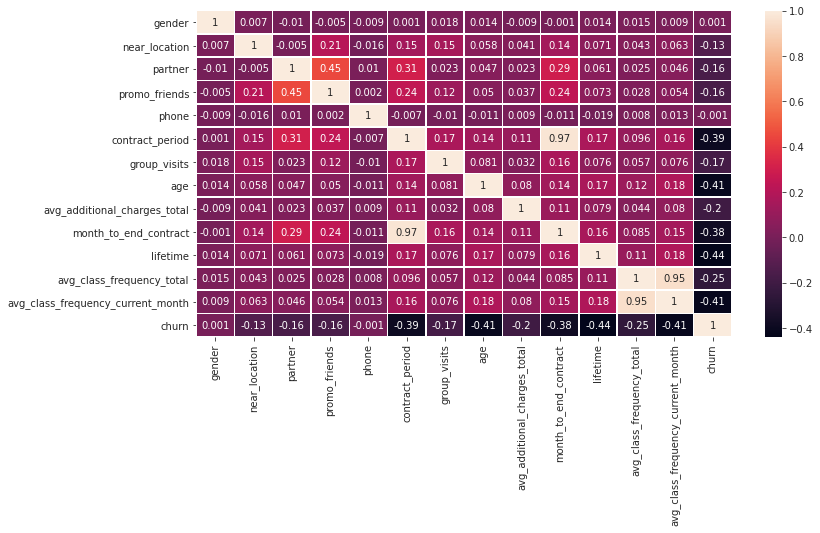

In [9]:
# матрица корреляций
corr = df.corr().round(3)

plt.figure(figsize = (12,6))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        linewidths=.5,
        annot=True);
corr

Некоторые признаки друг друга дублируют:

1. Срок до окончания текущего действующего абонемента и длительность текущего действующего абонемента
2. Средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц.

Я удалю длительность текущего действующего абонемента и среднюю частоту посещений в неделю за все время с начала действия абонемента, чтобы избежать паразитных связей и ошибок при обучении моделей, **мультиколлинеарности**.

In [10]:
learn = df.drop(['contract_period', 'avg_class_frequency_total'], axis=1)
learn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   group_visits                       4000 non-null   int64  
 6   age                                4000 non-null   int64  
 7   avg_additional_charges_total       4000 non-null   float64
 8   month_to_end_contract              4000 non-null   float64
 9   lifetime                           4000 non-null   int64  
 10  avg_class_frequency_current_month  4000 non-null   float64
 11  churn                              4000 non-null   int64

## Модель прогнозирования оттока клиентов <a id="3"></a>

In [11]:
# делю данные на признаки (матрица X) и целевую переменную (y)
X = learn.drop('churn', axis = 1)
y = learn['churn']

# делю модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# обучаю StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразую обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Логистическая регрессия

In [12]:
# задаю алгоритм для нашей модели
lr_model = LogisticRegression(solver='liblinear',random_state=0)

# обучаю модель
lr_model.fit(X_train_st, y_train)

# делаю прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,-1]

### Случайны лес 

In [13]:
# алгоритм случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
# обучаю модель случайного леса
rf_model.fit(X_train_st, y_train)
# делаю прогнозы
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:, -1] 

### Метрики

In [14]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

# метрики для случайного леса
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

# метрики для логистической регрессии
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.82
	Recall: 0.78
	F1: 0.80
	ROC_AUC: 0.95
Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
	F1: 0.81
	ROC_AUC: 0.96


Я обучал модели на стандартизированных данных.

* По доле правильных ответов у обеих метрик высокие показатели, но у случайного леса больше на 0.01 - 0.91
* По точности лучше так же случайный лес на 0.03 - 0.82
* Полнота лучше у логистической регрессии - 0.82. На 0.04 больше, чем у случайного леса.

Считаю, что **Recall наиболее релевантная метрика для нашего исследования.** Логистическая регрессия выглядит привлекательнее, особенно если избавиться от выбросов.

## Кластеризация клиентов <a id="4"></a>

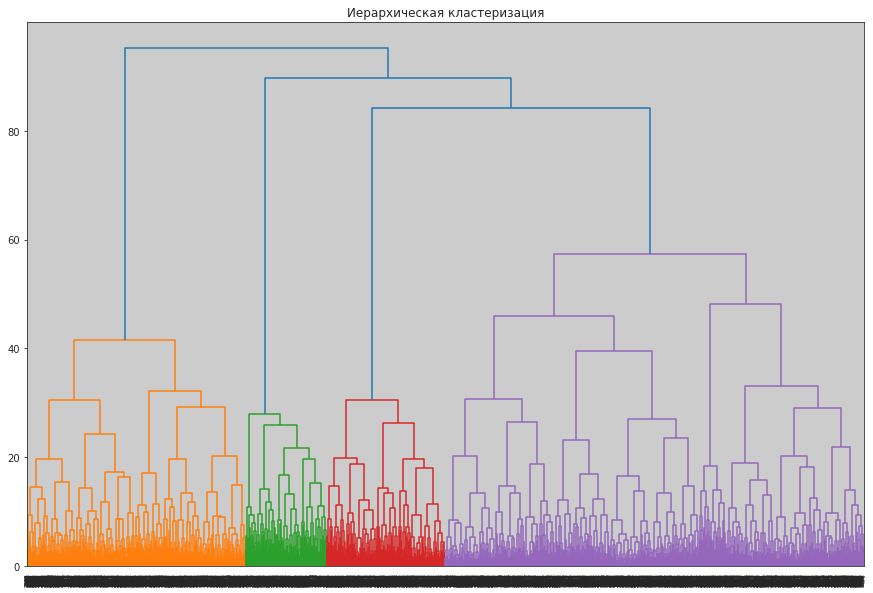

In [15]:
# стандартизация
sc = StandardScaler()
x_sc = sc.fit_transform(X)
# таблица связок
linked = linkage(x_sc, method = 'ward') 
# график
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

По дендограмме видно, что кластера 4, но последний фиолетовый очень объемный. Можно предположить 5 кластеров клиентов

### K-means

In [16]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)
# сохраняем метки кластера в поле нашего датасета
learn['cluster_km'] = pd.Series(labels)
# выводим статистику по средним значениям наших признаков по кластеру
learn.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
0,0.492000,0.994000,0.953000,1.000000,0.906000,0.528000,29.633000,154.086252,6.730000,4.287000,1.919105,0.108000
1,0.495352,0.998672,0.378486,0.046481,0.903054,0.000000,30.342629,174.392898,4.698539,5.166003,2.237272,0.046481
2,0.511194,1.000000,0.226368,0.114428,0.899254,0.182836,26.807214,111.073289,1.715174,1.420398,0.978977,0.741294
3,0.502455,0.000000,0.489362,0.072013,0.913257,0.232406,28.700491,137.375245,2.826514,3.027823,1.599583,0.400982
4,0.550481,0.998798,0.274038,0.075721,0.897837,1.000000,30.248798,155.206260,4.707933,4.483173,2.043261,0.092548


В группе №2 - 74% отток. Их лайфтайм самый низкий, самое низкое количество посещений зала в неделю, они меньше всех платят за дополнительные услуги.

In [17]:
learn.groupby('cluster_km').agg({'churn' : 'count'})

,churn
cluster_km,
0,1000
1,753
2,804
3,611
4,832


### Распределение признаков по класстерам

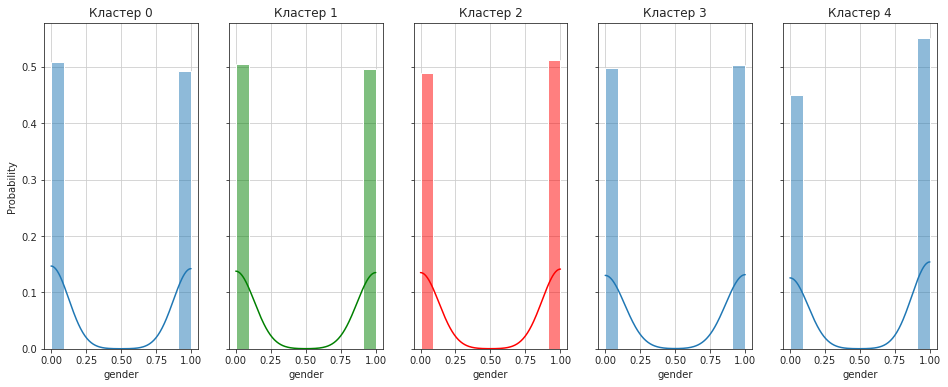

<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


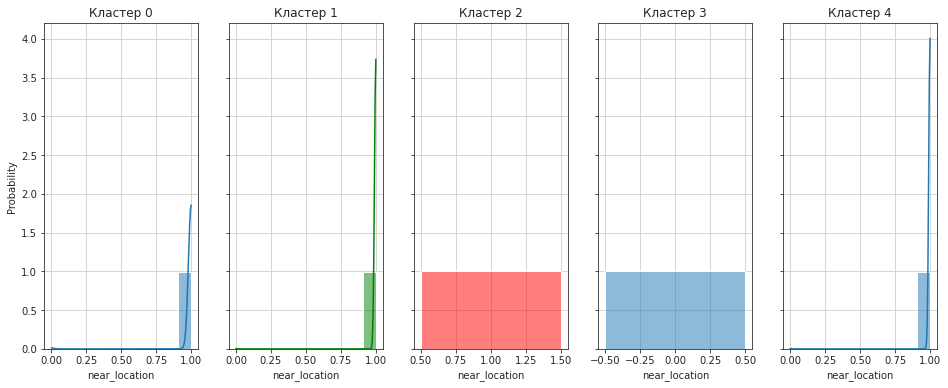

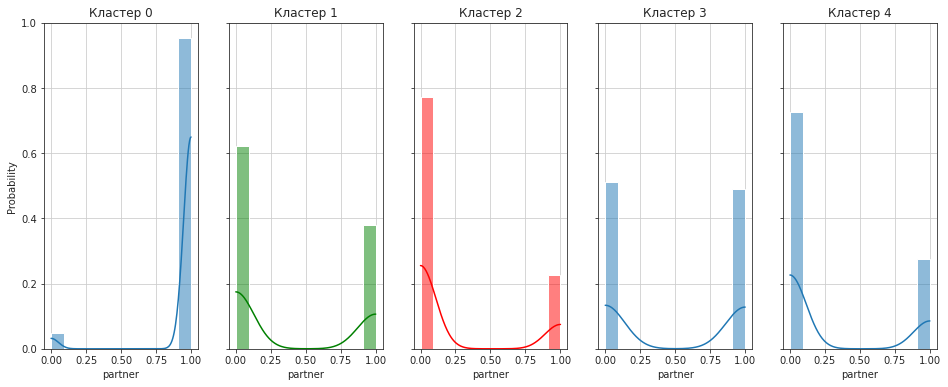

<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


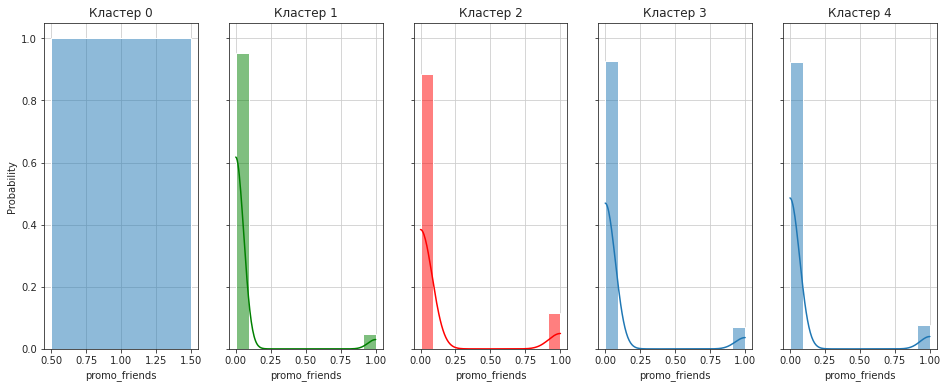

<Figure size 432x288 with 0 Axes>

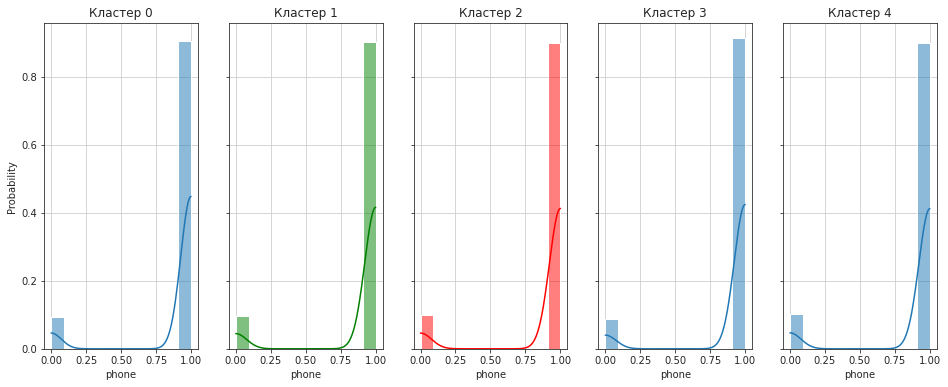

<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


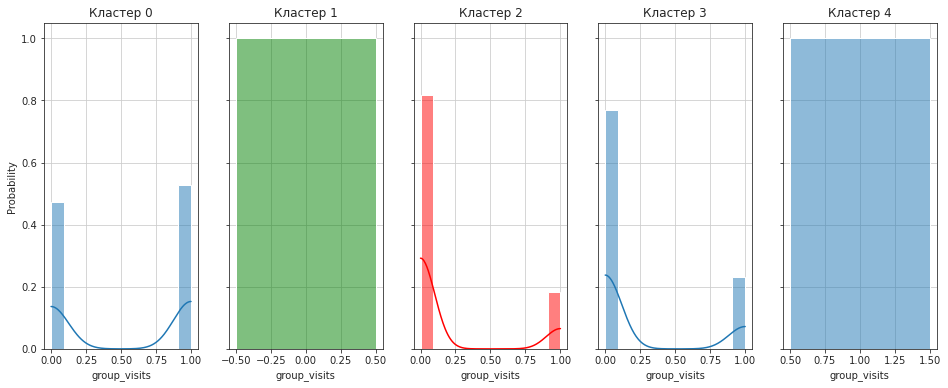

<Figure size 432x288 with 0 Axes>

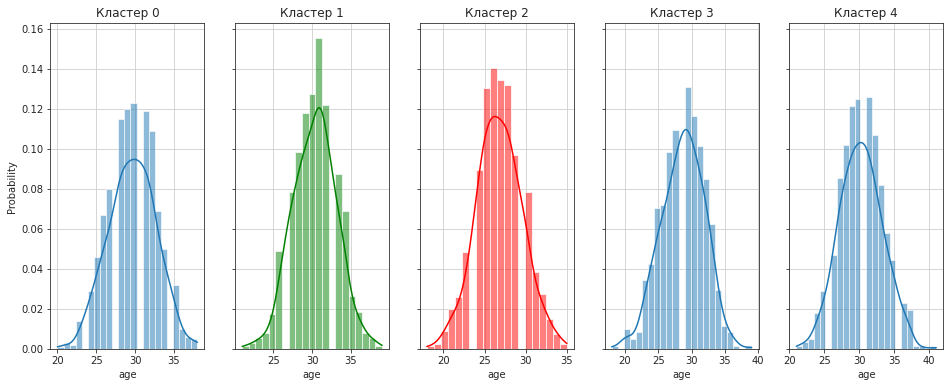

<Figure size 432x288 with 0 Axes>

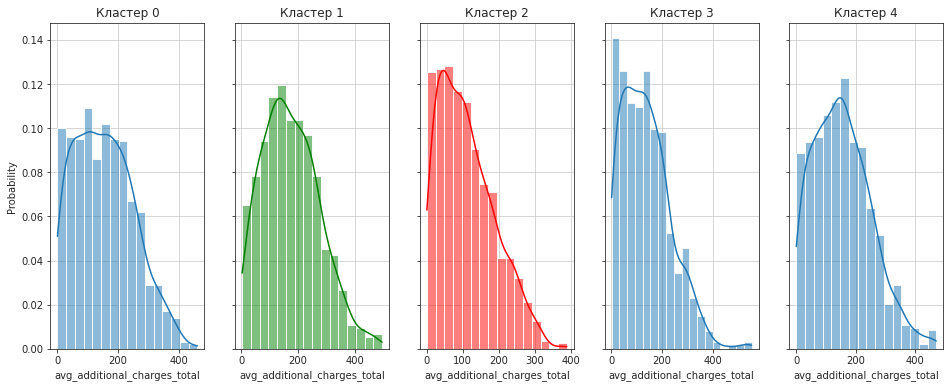

<Figure size 432x288 with 0 Axes>

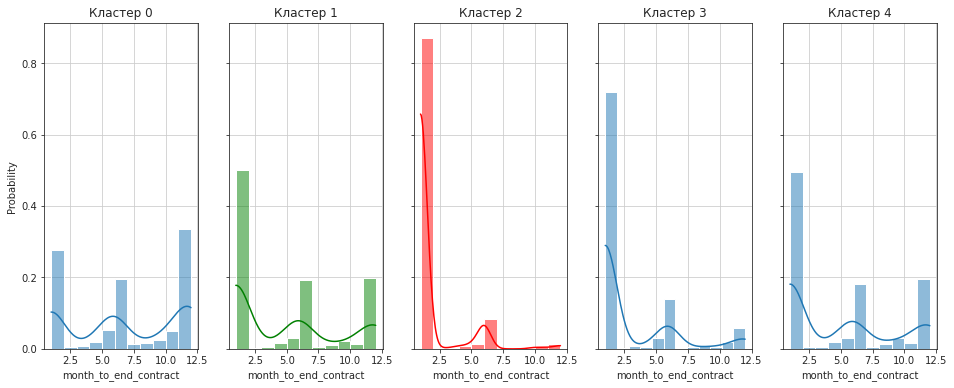

<Figure size 432x288 with 0 Axes>

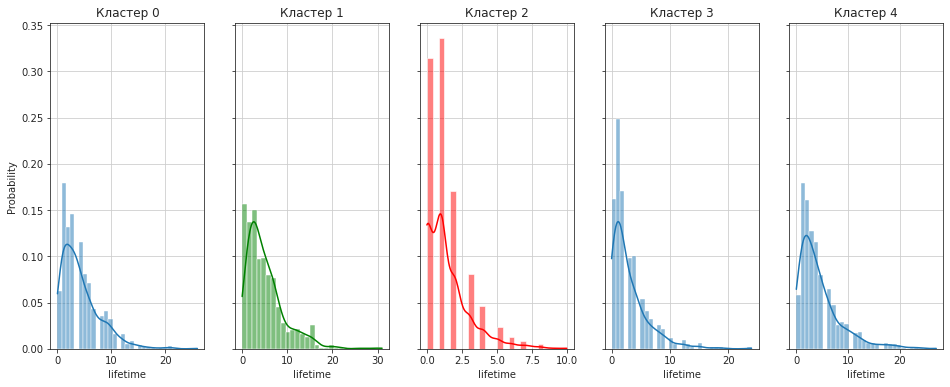

<Figure size 432x288 with 0 Axes>

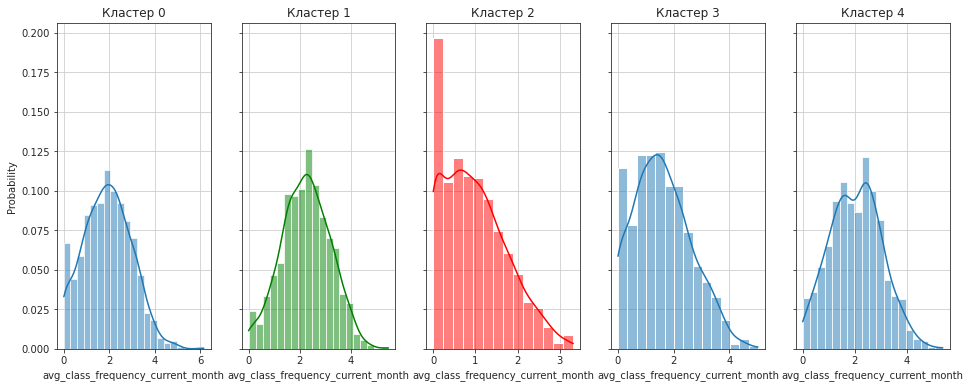

<Figure size 432x288 with 0 Axes>

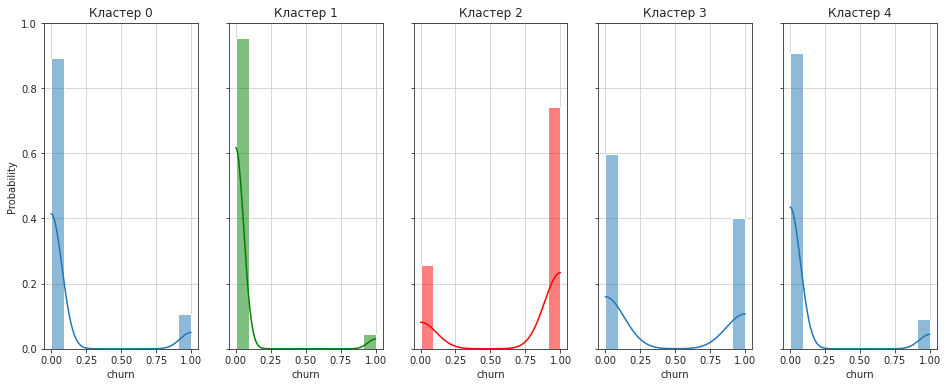

<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


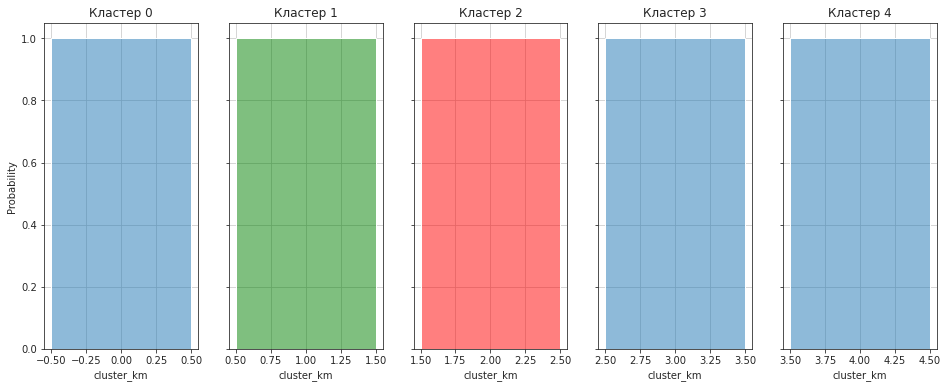

<Figure size 432x288 with 0 Axes>

In [18]:
for i, col in enumerate(learn.columns):
    fig, ((ax1), (ax2), (ax3), (ax4), (ax5)) = plt.subplots(ncols=5, nrows=1, figsize=(16, 6), sharey=True)
    plt.figure(i)
    sns.histplot(learn.query('cluster_km==0')[col], ax=ax1, kde=True, stat='probability').set(title='Кластер 0')   
    sns.histplot(learn.query('cluster_km==1')[col], ax=ax2, color='green', kde=True, stat='probability').set(title='Кластер 1')
    sns.histplot(learn.query('cluster_km==2')[col], ax=ax3, color='red', kde=True, stat='probability').set(title='Кластер 2')   
    sns.histplot(learn.query('cluster_km==3')[col], ax=ax4, kde=True, stat='probability').set(title='Кластер 3')
    sns.histplot(learn.query('cluster_km==4')[col], ax=ax5, kde=True, stat='probability').set(title='Кластер 4')
    plt.show()

In [19]:
learn.groupby('cluster_km').agg({'churn' : 'mean'})

,churn
cluster_km,
0,0.108000
1,0.046481
2,0.741294
3,0.400982
4,0.092548


## Общий вывод <a id="5"></a>

Алгоритм K-Means распределил клиентов по 5 группам. В кластере №2 оказался наиболее высокий **показатель оттока - 74%**. Кластер №3 - **46.4%.**
Наиболее низкий **в кластере №1 - 4.6%, на 2-ом месте кластер №4 - 9.2%.**.
В динамике по кластерам, исходя из гистограмм, видно:

* Чем меньше в среднем клиенты тратят на дополнительные услуги фитнес-центра, тем вероятнее, что они уйдут. Средняя выручка кластера №2 - **111**. Кластер №3 - **137**. Кластер №2 - **174**
* Срок до окончания абонемента. В кластере №2 **86%** имели сроко окончания **менее 2-х месяцев**.
* Время с момента первого обращения в фитнес-центр в кластере №2 у **30% клиентов меньше 1 месяца**, еще у **35% меньше 2 месяцев**.
* Средняя частота посещений в неделю за предыдущий месяц в кластере №2 у примерно **50% клиентов меньше 1 раза в неделю.** В кластере №1 больше 50% клиентов занимаются два раза в неделю.

Остальные факторы не имеют сильного влияния на отток.

**Стратегия и рекомендации по удержанию клиентов:**

1. Реклама дополнительных товаров и услуг в фитнес-центре.  Акции в стиле: "скидка на протеин(кофе, занятие с тренером) тем, кто ходит 2 раза в неделю в зал в месяц". Заодно комбинация с повышением количества посещений в неделю.
2. Персональная рассылка со скидками тем, у кого маленький средний чек по дополнительынм услугам и товарам.
3. Услуга автопродления абонемента. 
4. Рассылка-напоминание тем, у кого заканчивается абонемент. Предложение таким клиентам продолжить на выгодных условиях.
5. Давать первые два месяца бонусы за посещение фитнес-центра.